# Preprocessing

<span style="color: cyan;">Load data</span>

In [1]:
#libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from scipy import stats


In [2]:
# Define column names based on welddb.info

column_names = [
    'carbon_wt_pct',                    #1
    'silicon_wt_pct',                   #2
    'manganese_wt_pct',                 #3
    'sulphur_wt_pct',                   #4
    'phosphorus_wt_pct',                #5
    'nickel_wt_pct',                    #6
    'chromium_wt_pct',                  #7
    'molybdenum_wt_pct',                #8
    'vanadium_wt_pct',                  #9
    'copper_wt_pct',                    #10
    'cobalt_wt_pct',                    #11
    'tungsten_wt_pct',                  #12
    'oxygen_ppm',                       #13
    'titanium_ppm',                     #14
    'nitrogen_ppm',                     #15
    'aluminium_ppm',                    #16
    'boron_ppm',                        #17
    'niobium_ppm',                      #18
    'tin_ppm',                          #19
    'arsenic_ppm',                      #20
    'antimony_ppm',                     #21
    'current_a',                        #22
    'voltage_v',                        #23
    'ac_dc',                            #24
    'electrode_polarity',               #25
    'heat_input_kj_per_mm',             #26
    'interpass_temp_c',                 #27
    'weld_type',                        #28
    'pwht_temp_c',                      #29
    'pwht_time_h',                      #30
    'yield_strength_mpa',               #31
    'ultimate_tensile_strength_mpa',    #32
    'elongation_pct',                   #33
    'reduction_area_pct',               #34
    'charpy_temp_c',                    #35
    'charpy_toughness_j',               #36
    'hardness_kg_per_mm2',              #37
    'fatt50_pct',                       #38
    'primary_ferrite_pct',              #39
    'ferrite_second_phase_pct',         #40
    'acicular_ferrite_pct',             #41
    'martensite_pct',                   #42
    'ferrite_carbide_aggregate_pct',    #43
    'weld_id'                           #44
]

# Load the data
data = pd.read_csv('data/welddb.data', sep=r'\s+', names=column_names, na_values='N')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   carbon_wt_pct                  1652 non-null   float64
 1   silicon_wt_pct                 1652 non-null   float64
 2   manganese_wt_pct               1652 non-null   float64
 3   sulphur_wt_pct                 1648 non-null   object 
 4   phosphorus_wt_pct              1642 non-null   float64
 5   nickel_wt_pct                  697 non-null    float64
 6   chromium_wt_pct                784 non-null    float64
 7   molybdenum_wt_pct              793 non-null    object 
 8   vanadium_wt_pct                928 non-null    object 
 9   copper_wt_pct                  578 non-null    object 
 10  cobalt_wt_pct                  129 non-null    object 
 11  tungsten_wt_pct                75 non-null     object 
 12  oxygen_ppm                     1256 non-null   f

## Cleaning

<span style="color: cyan;">Gestion des colonnes avec valeurs numériques ambigues</span>

In [3]:
def clean_numeric(val):
    """Convert strings like '<0.002' to numeric values"""
    if pd.isna(val):
        return np.nan
    if isinstance(val, str):
        if val.startswith('<'):
            return float(val[1:]) * 0.5  # Use half the detection limit
        elif val.startswith('>'):
            return float(val[1:]) * 1.5  # Use 1.5x the upper limit
    return val

# Separate numeric and categorical features
categorical_features = ['ac_dc', 'electrode_polarity', 'weld_type']
numeric_feature_cols = [col for col in column_names if col not in categorical_features and col != 'weld_id']

# Apply cleaning to all numeric columns (features and targets)
for col in numeric_feature_cols:
    if col in data.columns:
        data[col] = data[col].apply(clean_numeric)
        data[col] = pd.to_numeric(data[col], errors='coerce')

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   carbon_wt_pct                  1652 non-null   float64
 1   silicon_wt_pct                 1652 non-null   float64
 2   manganese_wt_pct               1652 non-null   float64
 3   sulphur_wt_pct                 1648 non-null   float64
 4   phosphorus_wt_pct              1642 non-null   float64
 5   nickel_wt_pct                  697 non-null    float64
 6   chromium_wt_pct                784 non-null    float64
 7   molybdenum_wt_pct              793 non-null    float64
 8   vanadium_wt_pct                928 non-null    float64
 9   copper_wt_pct                  578 non-null    float64
 10  cobalt_wt_pct                  129 non-null    float64
 11  tungsten_wt_pct                75 non-null     float64
 12  oxygen_ppm                     1256 non-null   f

<span style="color: cyan;">Dummy variables</span>

In [4]:
# Convert categorical features to dummy variables
print("\nConverting categorical features to dummy variables...")
categorical_dummies = []
for cat_col in categorical_features:
    if cat_col in data.columns:
        # Create dummy variables, drop first to avoid multicollinearity
        dummies = pd.get_dummies(data[cat_col], prefix=cat_col, drop_first=True, dtype=float)
        categorical_dummies.append(dummies)
        print(f"  {cat_col}: {len(dummies.columns)} dummy variable(s) created")

# Combine all dummies into one DataFrame
if categorical_dummies:
    categorical_df = pd.concat(categorical_dummies, axis=1)
    dummy_feature_names = categorical_df.columns.tolist()
else:
    categorical_df = pd.DataFrame()
    dummy_feature_names = []

print(f"\nNumeric features ({len(numeric_feature_cols)}):")
print(f"{numeric_feature_cols}")
print(f"\nCategorical dummy features ({len(dummy_feature_names)}):")
print(f"{dummy_feature_names}\n\n")

# complete dataframe with numeric_feature_cols df and categorical_df
with_dummies = data.copy()
with_dummies.drop(columns=categorical_features, inplace=True)
with_dummies = pd.concat([with_dummies, categorical_df], axis=1)

print(with_dummies.info())




Converting categorical features to dummy variables...
  ac_dc: 1 dummy variable(s) created
  electrode_polarity: 2 dummy variable(s) created
  weld_type: 9 dummy variable(s) created

Numeric features (40):
['carbon_wt_pct', 'silicon_wt_pct', 'manganese_wt_pct', 'sulphur_wt_pct', 'phosphorus_wt_pct', 'nickel_wt_pct', 'chromium_wt_pct', 'molybdenum_wt_pct', 'vanadium_wt_pct', 'copper_wt_pct', 'cobalt_wt_pct', 'tungsten_wt_pct', 'oxygen_ppm', 'titanium_ppm', 'nitrogen_ppm', 'aluminium_ppm', 'boron_ppm', 'niobium_ppm', 'tin_ppm', 'arsenic_ppm', 'antimony_ppm', 'current_a', 'voltage_v', 'heat_input_kj_per_mm', 'interpass_temp_c', 'pwht_temp_c', 'pwht_time_h', 'yield_strength_mpa', 'ultimate_tensile_strength_mpa', 'elongation_pct', 'reduction_area_pct', 'charpy_temp_c', 'charpy_toughness_j', 'hardness_kg_per_mm2', 'fatt50_pct', 'primary_ferrite_pct', 'ferrite_second_phase_pct', 'acicular_ferrite_pct', 'martensite_pct', 'ferrite_carbide_aggregate_pct']

Categorical dummy features (12):
['ac_

<span style="color: cyan;">Delete columns with more than 50% missing values  <br/>
⚠️ All categorical features are kept since none of them have more than 50% missing values ⚠️</span>


In [5]:
# --------- Remove numeric features with too many missing values (>50%) ---------
missing_ratio = with_dummies.isna().mean()
cols = [c for c in with_dummies.columns if (missing_ratio[c] <= 0.5) or (c in dummy_feature_names)]
ready_dataset = with_dummies[cols].copy()

print(ready_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   carbon_wt_pct         1652 non-null   float64
 1   silicon_wt_pct        1652 non-null   float64
 2   manganese_wt_pct      1652 non-null   float64
 3   sulphur_wt_pct        1648 non-null   float64
 4   phosphorus_wt_pct     1642 non-null   float64
 5   vanadium_wt_pct       928 non-null    float64
 6   oxygen_ppm            1256 non-null   float64
 7   titanium_ppm          935 non-null    float64
 8   nitrogen_ppm          1183 non-null   float64
 9   aluminium_ppm         905 non-null    float64
 10  current_a             1404 non-null   float64
 11  voltage_v             1404 non-null   float64
 12  heat_input_kj_per_mm  1652 non-null   float64
 13  interpass_temp_c      1614 non-null   float64
 14  pwht_temp_c           1639 non-null   float64
 15  pwht_time_h          

<span style="color: cyan;">delete lines with >30% missing values</span>

In [6]:
# Compter les valeurs manquantes par ligne
missing_per_row = ready_dataset.isnull().sum(axis=1)

# Garder seulement les lignes avec ≤ 30% de valeurs manquantes
threshold_pct = 30
threshold_count = (threshold_pct / 100) * ready_dataset.shape[1]

# Cleaned dataframe
ready_dataset = ready_dataset[missing_per_row <= threshold_count]

# print new dataframe
print(ready_dataset.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   carbon_wt_pct         1652 non-null   float64
 1   silicon_wt_pct        1652 non-null   float64
 2   manganese_wt_pct      1652 non-null   float64
 3   sulphur_wt_pct        1648 non-null   float64
 4   phosphorus_wt_pct     1642 non-null   float64
 5   vanadium_wt_pct       928 non-null    float64
 6   oxygen_ppm            1256 non-null   float64
 7   titanium_ppm          935 non-null    float64
 8   nitrogen_ppm          1183 non-null   float64
 9   aluminium_ppm         905 non-null    float64
 10  current_a             1404 non-null   float64
 11  voltage_v             1404 non-null   float64
 12  heat_input_kj_per_mm  1652 non-null   float64
 13  interpass_temp_c      1614 non-null   float64
 14  pwht_temp_c           1639 non-null   float64
 15  pwht_time_h          

## Outliers, missing data part 2 and imputation

In [7]:
def detect_outliers_iqr(df, numeric_cols, multiplier=1.5):
    """
    Detect outliers using Interquartile Range (IQR) method
    
    Parameters:
    - df: DataFrame
    - numeric_cols: list of numeric columns
    - multiplier: IQR multiplier (1.5 standard, 3 for extreme outliers)
    
    Returns:
    - outliers_info: DataFrame with outlier statistics
    - outlier_mask: boolean mask of rows with outliers
    """
    outlier_counts = {}
    outlier_indices = set()
    
    for col in numeric_cols:
        if col in df.columns and df[col].notna().sum() > 0:
            try:
                # Convert to numeric, coercing errors to NaN
                col_data = pd.to_numeric(df[col], errors='coerce')
                if col_data.notna().sum() > 0:
                    Q1 = col_data.quantile(0.25)
                    Q3 = col_data.quantile(0.75)
                    IQR = Q3 - Q1
                    
                    lower_bound = Q1 - multiplier * IQR
                    upper_bound = Q3 + multiplier * IQR
                    
                    col_outliers = ((col_data < lower_bound) | (col_data > upper_bound)).sum()
                    outlier_counts[col] = col_outliers
                    
                    if col_outliers > 0:
                        outlier_indices.update(
                            df[(col_data < lower_bound) | (col_data > upper_bound)].index
                        )
                else:
                    outlier_counts[col] = 0
            except Exception as e:
                print(f"Warning: Could not process column '{col}': {e}")
                outlier_counts[col] = 0
    
    outliers_info = pd.DataFrame(list(outlier_counts.items()), 
                                  columns=['Column', 'Outlier_Count']).sort_values('Outlier_Count', ascending=False)
    
    outlier_mask = df.index.isin(outlier_indices)
    
    print("\n" + "=" * 70)
    print(f"OUTLIER DETECTION (IQR method, multiplier={multiplier})")
    print("=" * 70)
    print(outliers_info[outliers_info['Outlier_Count'] > 0].to_string())
    print(f"\nTotal rows with outliers: {outlier_mask.sum()} ({(outlier_mask.sum()/len(df))*100:.2f}%)")
    print("=" * 70)
    
    return outliers_info, outlier_mask

In [8]:
numeric_feature_cols = [col for col in ready_dataset.columns if col not in categorical_features and col != 'weld_id']
detect_outliers_iqr(ready_dataset, numeric_feature_cols, multiplier=1.5)


OUTLIER DETECTION (IQR method, multiplier=1.5)
                  Column  Outlier_Count
13      interpass_temp_c            550
10             current_a            310
26          weld_type_SA            261
18              ac_dc_DC            257
5        vanadium_wt_pct            176
8           nitrogen_ppm            166
12  heat_input_kj_per_mm            161
6             oxygen_ppm            156
1         silicon_wt_pct            153
3         sulphur_wt_pct            126
29         weld_type_TSA             87
11             voltage_v             83
7           titanium_ppm             82
4      phosphorus_wt_pct             76
0          carbon_wt_pct             63
9          aluminium_ppm             57
28        weld_type_ShMA             40
20  electrode_polarity_0             38
17    charpy_toughness_j             35
25       weld_type_NGSAW             18
16         charpy_temp_c             17
2       manganese_wt_pct             11
19  electrode_polarity_-        

(                  Column  Outlier_Count
 13      interpass_temp_c            550
 10             current_a            310
 26          weld_type_SA            261
 18              ac_dc_DC            257
 5        vanadium_wt_pct            176
 8           nitrogen_ppm            166
 12  heat_input_kj_per_mm            161
 6             oxygen_ppm            156
 1         silicon_wt_pct            153
 3         sulphur_wt_pct            126
 29         weld_type_TSA             87
 11             voltage_v             83
 7           titanium_ppm             82
 4      phosphorus_wt_pct             76
 0          carbon_wt_pct             63
 9          aluminium_ppm             57
 28        weld_type_ShMA             40
 20  electrode_polarity_0             38
 17    charpy_toughness_j             35
 25       weld_type_NGSAW             18
 16         charpy_temp_c             17
 2       manganese_wt_pct             11
 19  electrode_polarity_-              7
 24       weld_t

In [9]:
def detect_outliers_zscore(df, numeric_cols, threshold=3):
    """
    Detect outliers using Z-score method (more aggressive)
    
    Parameters:
    - df: DataFrame
    - numeric_cols: list of numeric columns
    - threshold: z-score threshold (3 for extreme, 2.5 for stricter)
    
    Returns:
    - outliers_info: DataFrame with outlier statistics
    - outlier_mask: boolean mask of rows with outliers
    """
    outlier_counts = {}
    outlier_indices = set()
    
    for col in numeric_cols:
        if col in df.columns and df[col].notna().sum() > 1:
            try:
                # Convert to numeric, coercing errors to NaN
                col_data = pd.to_numeric(df[col], errors='coerce')
                if col_data.notna().sum() > 1:
                    z_scores = np.abs(stats.zscore(col_data.dropna()))
                    col_outliers = (z_scores > threshold).sum()
                    outlier_counts[col] = col_outliers
                    
                    if col_outliers > 0:
                        outlier_indices.update(
                            df[np.abs(stats.zscore(col_data.fillna(col_data.mean()))) > threshold].index
                        )
                else:
                    outlier_counts[col] = 0
            except Exception as e:
                print(f"Warning: Could not process column '{col}': {e}")
                outlier_counts[col] = 0
    
    outliers_info = pd.DataFrame(list(outlier_counts.items()), 
                                  columns=['Column', 'Outlier_Count']).sort_values('Outlier_Count', ascending=False)
    
    outlier_mask = df.index.isin(outlier_indices)
    
    print("\n" + "=" * 70)
    print(f"OUTLIER DETECTION (Z-score method, threshold={threshold})")
    print("=" * 70)
    print(outliers_info[outliers_info['Outlier_Count'] > 0].to_string())
    print(f"\nTotal rows with outliers: {outlier_mask.sum()} ({(outlier_mask.sum()/len(df))*100:.2f}%)")
    print("=" * 70)
    
    return outliers_info, outlier_mask

In [10]:
detect_outliers_zscore(ready_dataset, numeric_feature_cols, threshold=3)


OUTLIER DETECTION (Z-score method, threshold=3)
                  Column  Outlier_Count
29         weld_type_TSA             87
11             voltage_v             79
8           nitrogen_ppm             50
28        weld_type_ShMA             40
20  electrode_polarity_0             38
7           titanium_ppm             34
6             oxygen_ppm             28
12  heat_input_kj_per_mm             26
9          aluminium_ppm             22
1         silicon_wt_pct             20
25       weld_type_NGSAW             18
0          carbon_wt_pct             18
4      phosphorus_wt_pct             12
15           pwht_time_h             11
3         sulphur_wt_pct             10
5        vanadium_wt_pct              9
24       weld_type_NGGMA              7
19  electrode_polarity_-              7
16         charpy_temp_c              5
22        weld_type_GTAA              4
27         weld_type_SAA              4
10             current_a              4
13      interpass_temp_c       

(                  Column  Outlier_Count
 29         weld_type_TSA             87
 11             voltage_v             79
 8           nitrogen_ppm             50
 28        weld_type_ShMA             40
 20  electrode_polarity_0             38
 7           titanium_ppm             34
 6             oxygen_ppm             28
 12  heat_input_kj_per_mm             26
 9          aluminium_ppm             22
 1         silicon_wt_pct             20
 25       weld_type_NGSAW             18
 0          carbon_wt_pct             18
 4      phosphorus_wt_pct             12
 15           pwht_time_h             11
 3         sulphur_wt_pct             10
 5        vanadium_wt_pct              9
 24       weld_type_NGGMA              7
 19  electrode_polarity_-              7
 16         charpy_temp_c              5
 22        weld_type_GTAA              4
 27         weld_type_SAA              4
 10             current_a              4
 13      interpass_temp_c              4
 21        weld_

In [11]:
# Mark outliers as NaN for imputation
def mark_outliers_as_nan(df, numeric_cols, threshold=3):
    df_marked = df.copy()
    outliers_count = {}
    
    for col in numeric_cols:
        if col in df_marked.columns:
            try:
                # Convert to numeric
                col_data = pd.to_numeric(df_marked[col], errors='coerce')
                
                if col_data.notna().sum() > 1:
                    # Calculate z-scores
                    z_scores = np.abs(stats.zscore(col_data.fillna(col_data.mean())))
                    
                    # Mark outliers as NaN
                    outlier_mask = z_scores > threshold
                    n_outliers = outlier_mask.sum()
                    outliers_count[col] = n_outliers
                    
                    df_marked.loc[outlier_mask, col] = np.nan
                    
                    if n_outliers > 0:
                        print(f"{col}: {n_outliers} outliers marked as NaN")
            except Exception as e:
                print(f"Error processing {col}: {e}")
    
    print(f"\nTotal outliers marked: {sum(outliers_count.values())}")
    return df_marked

# Usage
ready_dataset = mark_outliers_as_nan(ready_dataset, numeric_feature_cols, threshold=3)
print(f"\nMissing values before: {ready_dataset.isnull().sum().sum()}")
print(f"Missing values after marking outliers: {ready_dataset.isnull().sum().sum()}")

carbon_wt_pct: 18 outliers marked as NaN
silicon_wt_pct: 20 outliers marked as NaN
sulphur_wt_pct: 10 outliers marked as NaN
phosphorus_wt_pct: 12 outliers marked as NaN
vanadium_wt_pct: 9 outliers marked as NaN
oxygen_ppm: 34 outliers marked as NaN
titanium_ppm: 37 outliers marked as NaN
nitrogen_ppm: 73 outliers marked as NaN
aluminium_ppm: 55 outliers marked as NaN
current_a: 30 outliers marked as NaN
voltage_v: 83 outliers marked as NaN
heat_input_kj_per_mm: 26 outliers marked as NaN
interpass_temp_c: 4 outliers marked as NaN
pwht_time_h: 11 outliers marked as NaN
charpy_temp_c: 19 outliers marked as NaN
charpy_toughness_j: 31 outliers marked as NaN
electrode_polarity_-: 7 outliers marked as NaN
electrode_polarity_0: 38 outliers marked as NaN
weld_type_GMAA: 4 outliers marked as NaN
weld_type_GTAA: 4 outliers marked as NaN
weld_type_NGGMA: 7 outliers marked as NaN
weld_type_NGSAW: 18 outliers marked as NaN
weld_type_SAA: 4 outliers marked as NaN
weld_type_ShMA: 40 outliers marked a

In [12]:
ready_dataset.shape

(1652, 31)

In [13]:
ready_dataset.isnull().sum().sort_values(ascending=False)

charpy_toughness_j      804
aluminium_ppm           802
charpy_temp_c           792
titanium_ppm            754
vanadium_wt_pct         733
nitrogen_ppm            542
oxygen_ppm              430
voltage_v               331
current_a               278
weld_type_TSA            87
interpass_temp_c         42
weld_type_ShMA           40
electrode_polarity_0     38
heat_input_kj_per_mm     26
pwht_time_h              24
phosphorus_wt_pct        22
silicon_wt_pct           20
weld_type_NGSAW          18
carbon_wt_pct            18
sulphur_wt_pct           14
pwht_temp_c              13
electrode_polarity_-      7
weld_type_NGGMA           7
weld_type_GMAA            4
weld_type_GTAA            4
weld_type_SAA             4
weld_id                   0
ac_dc_DC                  0
weld_type_MMA             0
weld_type_SA              0
manganese_wt_pct          0
dtype: int64

In [14]:
def impute_missing_values(df, numeric_cols, method='knn', n_neighbors=5):
    """
    Impute missing values AND marked outliers using different strategies
    
    Parameters:
    - df: DataFrame (with outliers already marked as NaN)
    - numeric_cols: list of numeric columns
    - method: 'knn'
    - n_neighbors: for KNN imputation
    
    Returns:
    - df_imputed: DataFrame with imputed values
    - imputation_report: report of imputation operations
    """
    df_imputed = df.copy()
    missing_before = df_imputed[numeric_cols].isnull().sum().sum()
    
    print("\n" + "=" * 70)
    print(f"IMPUTATION (method: {method})")
    print("=" * 70)
    print(f"Total missing/outlier values before imputation: {missing_before}")
    
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed[numeric_cols] = knn_imputer.fit_transform(df_imputed[numeric_cols])
    method_desc = f'KNN with {n_neighbors} neighbors'
    
    missing_after = df_imputed[numeric_cols].isnull().sum().sum()
    
    print(f"Total missing/outlier values after imputation: {missing_after}")
    print(f"Method used: {method_desc}")
    print(f"Values imputed: {missing_before - missing_after}")
    print("=" * 70)
    
    imputation_report = {
        'method': method_desc,
        'missing_before': missing_before,
        'missing_after': missing_after,
        'values_imputed': missing_before - missing_after
    }
    
    return df_imputed, imputation_report

In [15]:
ready_dataset, imputation_report = impute_missing_values(ready_dataset, numeric_feature_cols, method='knn', n_neighbors=5)


IMPUTATION (method: knn)
Total missing/outlier values before imputation: 5854
Total missing/outlier values after imputation: 0
Method used: KNN with 5 neighbors
Values imputed: 5854


## Feature analysis

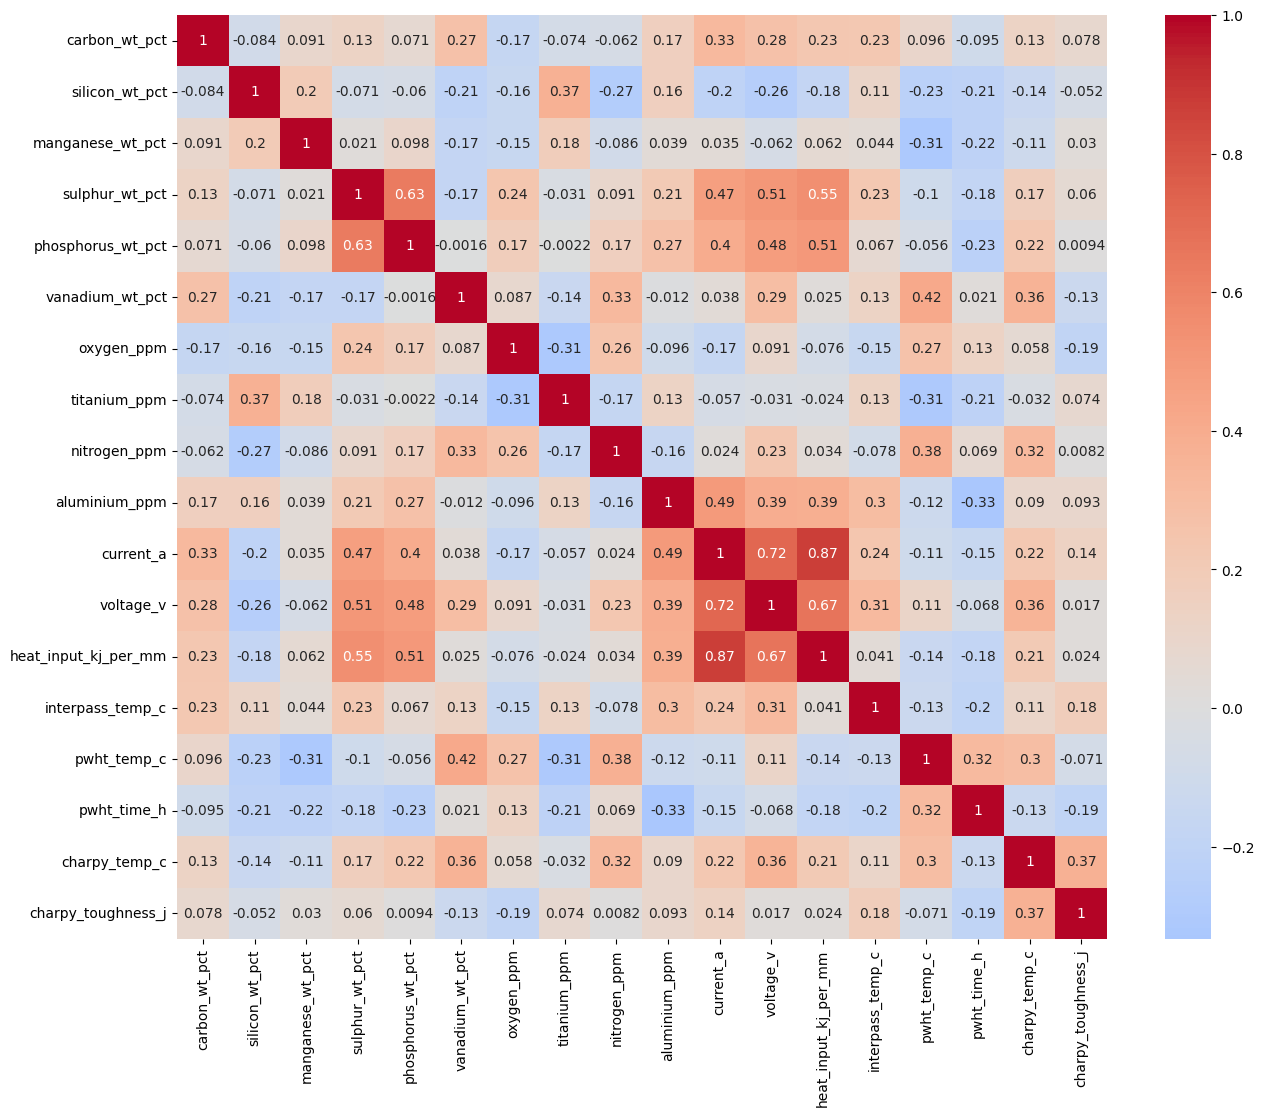

In [16]:
cat_cols = ['ac_dc_DC', 'electrode_polarity_-', 'electrode_polarity_0', 
                'weld_type_GMAA', 'weld_type_GTAA', 'weld_type_MMA', 
                'weld_type_NGGMA', 'weld_type_NGSAW', 'weld_type_SA', 
                'weld_type_SAA', 'weld_type_ShMA', 'weld_type_TSA']

ready_dataset_num = ready_dataset.drop(columns=cat_cols)

plt.figure(figsize=(15, 12))
sns.heatmap(ready_dataset_num.corr(numeric_only=True), cmap='coolwarm', center=0, annot=True)
plt.show()

### Impureté 

Observation : Sulphur (0.63) et Phosphorus (0.63) ont les plus fortes corrélations avec charpy_toughness
Justification physique : Les impuretés (S, P) sont des ductility killers en soudure. Elles créent des fragilités intergranulaires
Features à créer :

impurities_index = sulphur_wt_pct + phosphorus_wt_pct
sulphur_phosphorus_ratio = sulphur_wt_pct / (phosphorus_wt_pct + 1e-6) in case P = 0 

In [17]:
impurities_index = ready_dataset['sulphur_wt_pct'] + ready_dataset['phosphorus_wt_pct']
sulphur_phosphorus_ratio = ready_dataset['sulphur_wt_pct'] / (ready_dataset['phosphorus_wt_pct'] + 1e-6)

ready_dataset['impurities_index'] = impurities_index    
ready_dataset['sulphur_phosphorus_ratio'] = sulphur_phosphorus_ratio

### PARAMÈTRES ÉLECTRIQUES 

Observation : Current (0.72) et Voltage (0.67) ont une forte corrélation entre eux ET avec heat_input (0.87, 0.67)
Justification physique : Le courant et la tension contrôlent l'apport thermique. Heat input = (Current × Voltage × Temps) / Longueur
Features à créer :

power_input_kw = (current_a * voltage_v) / 1000 - Énergie totale
power_efficiency = heat_input_kj_per_mm / (current_a * voltage_v + 1e-6) - Efﬁcacité énergétique
current_density_proxy = current_a / voltage_v - Rapport pour refroidissement

In [18]:
power_input_kw = (ready_dataset['current_a'] * ready_dataset['voltage_v']) / 1000 
power_efficiency = ready_dataset['heat_input_kj_per_mm'] / (ready_dataset['current_a'] * ready_dataset['voltage_v'] + 1e-6) 
current_density_proxy = ready_dataset['current_a'] / ready_dataset['voltage_v'] 

ready_dataset['power_input_kw'] = power_input_kw
ready_dataset['power_efficiency'] = power_efficiency        
ready_dataset['current_density_proxy'] = current_density_proxy

###  CARBONE & MANGANÈSE

Observation : Carbon (0.27) et Manganese (0.2) ont corrélation modérée avec toughness
Justification physique :

Carbone augmente la dureté MAIS réduit la ténacité (trade-off classique)
Manganèse aide au durcissement mais peut créer de la fragilité à froid

Features à créer :

hardenability_index = carbon_wt_pct + (manganese_wt_pct / 6) - Classique Carbon Equivalent (CEQ)
carbon_manganese_ratio = carbon_wt_pct / (manganese_wt_pct + 0.1) - Équilibre C/Mn

In [19]:
hardenability_index = ready_dataset['carbon_wt_pct'] + (ready_dataset['manganese_wt_pct'] / 6) 
carbon_manganese_ratio = ready_dataset['carbon_wt_pct']/ (ready_dataset['manganese_wt_pct'] + 0.1) 

###  PARAMÈTRES THERMIQUES

Observation :

Heat_input corrélé avec current (0.87), voltage (0.67)
Interpass_temp faiblement corrélé (0.041 avec toughness)

Justification physique :

Heat input contrôle la vitesse de refroidissement (affecte la microstructure)
Interpass temperature ralentit le refroidissement entre passes (réduit les contraintes)

Features à créer :

cooling_rate_proxy = heat_input_kj_per_mm / (interpass_temp_c + 273) - Taux de refroidissement normalisé
thermal_cycle_intensity = heat_input_kj_per_mm * (1 / (interpass_temp_c + 1)) - Intensité du cycle thermique

In [20]:
cooling_rate_proxy = ready_dataset['heat_input_kj_per_mm'] / ( ready_dataset['interpass_temp_c'] + 273) 
thermal_cycle_intensity = ready_dataset['heat_input_kj_per_mm'] * (1 / (ready_dataset['interpass_temp_c'] + 1))

ready_dataset['hardenability_index'] = hardenability_index
ready_dataset['carbon_manganese_ratio'] = carbon_manganese_ratio

ready_dataset['cooling_rate_proxy'] = cooling_rate_proxy
ready_dataset['thermal_cycle_intensity'] = thermal_cycle_intensity

## PCA

On récupère juste le nouveau dataset composé de valeurs numériques et des nouvelles features créées que je vais lister ici
- impuretés : impurities_index, sulphur_phosphorus_ratio
- electriques : power_input_kw, power_efficiency, current_density_proxy
- carbone/ manganèse : hardenability_index, carbon_manganese_ratio
- thermiques : cooling_rate_proxy, thermal_cycle_intensity


In [21]:
ready_dataset_num = ready_dataset.drop(columns=cat_cols)
ready_dataset_num = ready_dataset_num.select_dtypes(include=[np.number])
print(ready_dataset_num.info())

scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(ready_dataset_num)

pca = PCA()
pca_data = pca.fit_transform(scaled_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   carbon_wt_pct             1652 non-null   float64
 1   silicon_wt_pct            1652 non-null   float64
 2   manganese_wt_pct          1652 non-null   float64
 3   sulphur_wt_pct            1652 non-null   float64
 4   phosphorus_wt_pct         1652 non-null   float64
 5   vanadium_wt_pct           1652 non-null   float64
 6   oxygen_ppm                1652 non-null   float64
 7   titanium_ppm              1652 non-null   float64
 8   nitrogen_ppm              1652 non-null   float64
 9   aluminium_ppm             1652 non-null   float64
 10  current_a                 1652 non-null   float64
 11  voltage_v                 1652 non-null   float64
 12  heat_input_kj_per_mm      1652 non-null   float64
 13  interpass_temp_c          1652 non-null   float64
 14  pwht_tem

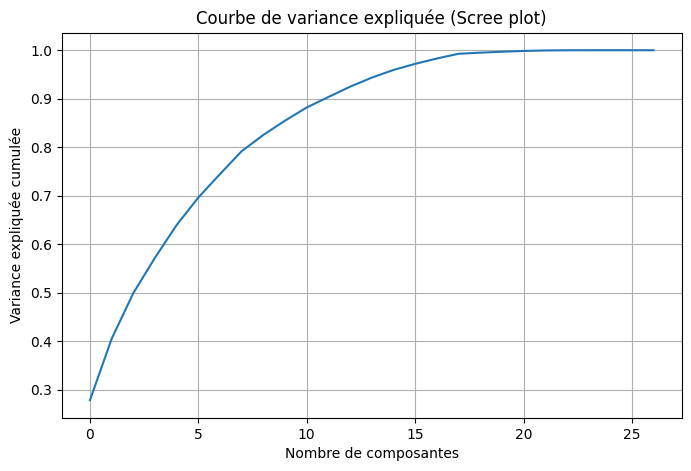

In [22]:
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('Courbe de variance expliquée (Scree plot)')
plt.grid(True)
plt.show()

On observe que la variance atteint 90% et se stabilise à partir de 11 composantes. Ainsi, la rétention de 11 composantes principales apparaît comme un compromis optimal entre réduction de dimension et préservation de l’information.

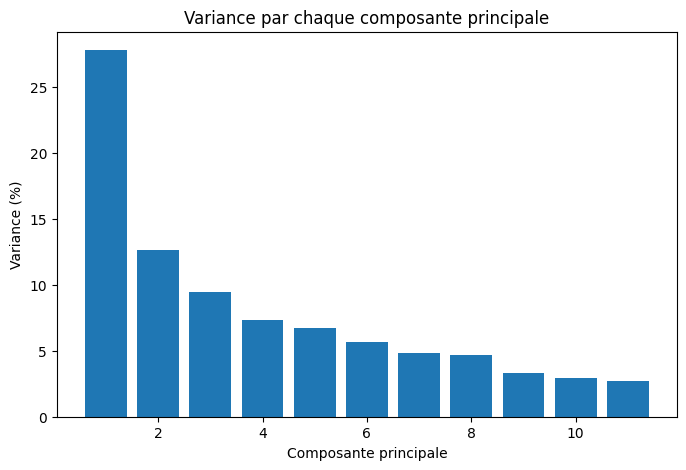

In [23]:
pca = PCA(n_components=11)
pca_result = pca.fit_transform(scaled_dataset)

plt.figure(figsize=(8,5))
plt.bar(range(1, 12), pca.explained_variance_ratio_ * 100)
plt.xlabel('Composante principale')
plt.ylabel('Variance (%)')
plt.title('Variance par chaque composante principale')
plt.show()


On affiche les coefficients de chaque variable originale pour les 10 premières composantes principales (PC1 à PC10).

In [24]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(11)],
    index=ready_dataset_num.columns
)

print(loadings)


                               PC1       PC2       PC3       PC4       PC5  \
carbon_wt_pct             0.126650 -0.052060 -0.312136 -0.100030 -0.080751   
silicon_wt_pct           -0.075491  0.278806 -0.037964 -0.002808  0.135902   
manganese_wt_pct          0.021381  0.398911  0.023684 -0.323116 -0.185522   
sulphur_wt_pct            0.242184  0.028163  0.206086  0.034796  0.413095   
phosphorus_wt_pct         0.230828  0.035923  0.283483 -0.232647  0.166034   
vanadium_wt_pct           0.026606 -0.283090 -0.140469 -0.361319 -0.174610   
oxygen_ppm               -0.015373 -0.199865  0.303269 -0.124255  0.218753   
titanium_ppm             -0.014091  0.261306 -0.080525 -0.003135  0.083502   
nitrogen_ppm              0.036603 -0.249519  0.143404 -0.318104  0.002781   
aluminium_ppm             0.183067  0.113900 -0.165327 -0.015816  0.080803   
current_a                 0.339087  0.002431 -0.139702  0.105874 -0.082657   
voltage_v                 0.291933 -0.128731 -0.071510 -0.124574

Par exemple, pour les composantes principales PC1 et PC2, il est possible d’identifier les variables les plus influentes.

On observe que PC1 reflète principalement les données électriques et thermiques. Parmi les features les plus importantes, on retrouve celles que nous avions créées, ce qui confirme leur pertinence : `power_input_kw`, `current_density_proxy`, `cooling_rate_proxy`, `thermal_cycle_intensity` et `impurities_index`. 

En revanche, PC2 est davantage influencé par les composantes moléculaires, comme le manganèse. On remarque également que la feature créée `hardenability_index` apparaît parmi les plus significatives, soulignant sa valeur explicative.

In [25]:
pc1_values = pca_data[:, 0]  # projections sur PC1
correlations = pd.Series(np.corrcoef(pc1_values, ready_dataset_num.T)[0,1:], index=ready_dataset_num.columns)
print(correlations.sort_values(ascending=False))

power_input_kw              0.942561
current_a                   0.929108
heat_input_kj_per_mm        0.925835
cooling_rate_proxy          0.883267
current_density_proxy       0.850118
voltage_v                   0.799905
thermal_cycle_intensity     0.771970
impurities_index            0.714494
sulphur_wt_pct              0.663590
phosphorus_wt_pct           0.632476
aluminium_ppm               0.501608
carbon_wt_pct               0.347024
charpy_temp_c               0.325593
interpass_temp_c            0.203196
carbon_manganese_ratio      0.184874
hardenability_index         0.166565
charpy_toughness_j          0.118187
nitrogen_ppm                0.100294
vanadium_wt_pct             0.072901
manganese_wt_pct            0.058584
sulphur_phosphorus_ratio   -0.013889
titanium_ppm               -0.038610
oxygen_ppm                 -0.042123
pwht_temp_c                -0.090435
silicon_wt_pct             -0.206846
pwht_time_h                -0.245701
power_efficiency           -0.283844
d

In [26]:
pc2_values = pca_data[:, 1]  # projections sur PC2
correlations = ready_dataset_num.apply(lambda x: np.corrcoef(x, pc2_values)[0,1])
correlations_sorted = correlations.sort_values(ascending=False)
print(correlations_sorted)

manganese_wt_pct            0.737711
hardenability_index         0.644779
silicon_wt_pct              0.515600
titanium_ppm                0.483236
aluminium_ppm               0.210636
interpass_temp_c            0.120948
power_efficiency            0.105153
charpy_toughness_j          0.086793
impurities_index            0.066447
phosphorus_wt_pct           0.066433
sulphur_wt_pct              0.052083
heat_input_kj_per_mm        0.048666
current_density_proxy       0.034001
cooling_rate_proxy          0.026563
current_a                   0.004496
thermal_cycle_intensity     0.002047
sulphur_phosphorus_ratio   -0.004448
power_input_kw             -0.010314
carbon_wt_pct              -0.096274
voltage_v                  -0.238064
charpy_temp_c              -0.337792
oxygen_ppm                 -0.369612
pwht_time_h                -0.417676
nitrogen_ppm               -0.461438
vanadium_wt_pct            -0.523521
carbon_manganese_ratio     -0.631604
pwht_temp_c                -0.700067
d

In [28]:
import pickle

# Save processed data with PCA components
# Create a dataframe with PCA components
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(11)])

# Combine original data with PCA components
ready_dataset_with_pca = pd.concat([ready_dataset.reset_index(drop=True), pca_df], axis=1)

# Save to CSV
ready_dataset_with_pca.to_csv('data/processed_welddb.csv', index=False)

print(f"Data saved with {ready_dataset_with_pca.shape[1]} columns including 11 PCA components")
print(f"PCA columns: {pca_df.columns.tolist()}")

# Save PCA object and scaler for reuse
with open('data/pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)
    
with open('data/scaler_model.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nPCA model saved to 'data/pca_model.pkl'")
print("Scaler model saved to 'data/scaler_model.pkl'")
print(f"PCA explains {pca.explained_variance_ratio_.sum()*100:.2f}% of variance")

Data saved with 51 columns including 11 PCA components
PCA columns: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11']

PCA model saved to 'data/pca_model.pkl'
Scaler model saved to 'data/scaler_model.pkl'
PCA explains 88.19% of variance


## Data analyse

## Justification of target variables